# Unsupervised Learning

This practical session is designed to implement K-means Clustering, Principal Component Analysis and Anomaly Detection. [The MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/) is used for experiments.

## Dataset
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset consists of handwritten grayscale digit images. All handwritten digit images have been size-normalized and centered in a fixed size image of 28 x 28 pixels. A grayscale image is nothing but a 2D array of integers between 0 and 255. In the original dataset each pixel of the image is represented by a value between 0 and 255, where 0 is black, 255 is white and anything in between is a different shade of grey. In this lab session, we will use inverted and normalised pixel values (see `load_dataset()` for further details). Furthermore, we will only use 1,000 samples per digit. Below is some examples of [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digits:

![MNIST](./images/mnist-samples.png)


## References
[1] http://yann.lecun.com/exdb/mnist/

[2] https://pjreddie.com/projects/mnist-in-csv/

## Dataset Loading and Visualisation
The following function loads train and test handwritten digit image samples from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

In [1]:
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np

In [2]:
def load_dataset(train_dataset='./dataset/mnist_train.csv', test_dataset='./dataset/mnist_test.csv', samples_per_digit=1000):
    """
    Loads and returns train and test datasets.
    """
    np.random.seed(7)
    data_train = np.genfromtxt(fname=train_dataset, delimiter=',')
    y = data_train[:,0].astype(np.int)
    x = data_train[:,1:]    
    x = 255.0 - x
    x = x / 255.0
    labels = np.unique(y)
    for l in np.arange(len(labels)):
        index = np.where(y==labels[l])[0]
        np.random.shuffle(index)        
        if l == 0:
            x_train = x[index[0:samples_per_digit]]
            y_train = y[index[0:samples_per_digit]]
        else:
            x_train = np.vstack((x_train, x[index[0:samples_per_digit]]))
            y_train = np.hstack((y_train, y[index[0:samples_per_digit]]))   
    
    data_test = np.genfromtxt(fname=test_dataset, delimiter=',')
    
    y = data_test[:,0].astype(np.int)
    x = data_test[:,1:]    
    x = 255.0 - x
    x = x / 255.0
    labels = np.unique(y)
    for l in np.arange(len(labels)):
        index = np.where(y==labels[l])[0]
        np.random.shuffle(index)
        if l == 0:
            x_test = x[index[0:samples_per_digit]]
            y_test = y[index[0:samples_per_digit]]
        else:
            x_test = np.vstack((x_test, x[index[0:samples_per_digit]]))
            y_test = np.hstack((y_test, y[index[0:samples_per_digit]]))
    
    return (x_train, y_train, x_test, y_test)

The following script calls function `load_dataset()` to load train and test datasets. _Be patient as it may take some time to load datasets!_

In [3]:
x_train, y_train, x_test, y_test = load_dataset()

Each row of `x_train` and `x_test` variables is a 1D vector comprised of 784 (28 * 28) real numbers in [0,1] and refers to an unpacked handwritten digit image. The following function takes a 1D vector array as input and returns the corresponding 2D representation as image.

In [4]:
def vector2image(image_vector, image_height=28, image_width=28):
    """
    Returns image representation of the input 1D vector.
    """
    image = np.reshape(image_vector, (image_height, image_width))
    return image

Now you can use `vector2image()` function to convert a 1D feature vector to 2D image for visualisation purposes, e.g.:

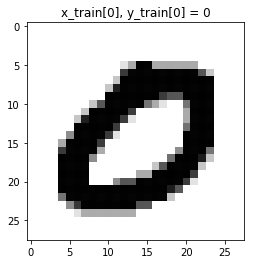

In [5]:
index = 0
image = vector2image(x_train[index])
pl.figure()
pl.imshow(image, cmap='gray')
pl.title('x_train[' + str(index) + '], ' + 'y_train[' + str(index) + '] = ' + str(int(y_train[index])))
pl.show()

You may also need the following function to convert a 2D grayscale image to 1D vector representation.

In [6]:
def image2vector(image):
    """
    Returns vector representation of the input 2D image.
    """
    image_height, image_width = image.shape
    image_vector = np.reshape(image, image_height*image_width)
    return image_vector

Thus, `vector2image(image2vector(vector2image(x_train[index])))` must produce exactly same output with that of `vector2image(x_train[index])`, i.e.:

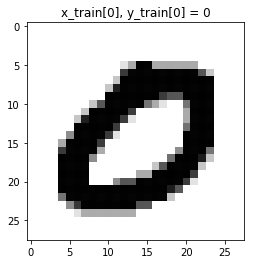

In [7]:
image = vector2image(image2vector(vector2image(x_train[index])))
pl.figure()
pl.imshow(image, cmap='gray')
pl.title('x_train[' + str(index) + '], ' + 'y_train[' + str(index) + '] = ' + str(int(y_train[index])))
pl.show()

Now, let's produce an image that is similar to what you see on the very first markdown cell by selecting samples from `x_train` and `y_train`!

In [8]:
def image_digits(x_train, y_train, K=10, S=16, image_loc='./images/mnist-samples.png'):
    """
    Creates, shows and saves an image of digit samples from MNIST dataset.  
    K is the number of digits and S is the number of samples per digit.
    """
    for k in np.arange(K):
        for s in np.arange(S):
            image = vector2image(x_train[y_train==k][s])
            if s == 0:
                image_digits_row = image
            else:
                image_digits_row = np.hstack((image_digits_row, image))
        if k == 0:
            image_digits = image_digits_row
        else:
            image_digits = np.vstack((image_digits, image_digits_row))
    pl.figure()
    pl.imshow(image_digits, cmap='gray')
    pl.axis('off')
    # save a copy of this image as png file under ./images folder
    pl.imsave(image_loc, image_digits, cmap='gray') 

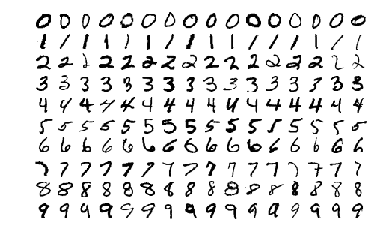

In [9]:
image_digits(x_train, y_train)

We are ready to implement $K$-means clustering. We will use `x_train` and `y_train` in our experiments.

## $K$-means Clustering

In [10]:
class Kmeans:
    def __init__(self, x, c, suppress_output=True):
        self.x = x # input dataset
        self.c = c.copy() # initial cluster centroids                         
        self.N = x.shape[0] # the number of data points
        self.K = c.shape[0] # the number of clusters (K)        
        self.a = np.zeros(self.N, dtype=np.int) # class assignment vector
        self.a_previous = np.ones(self.N, dtype=np.int) # class assignment vector from the previous iteration
        self.distance_matrix = np.zeros((self.N, self.K), dtype=np.float) # each column of this matrix is distance from the corresponding cluster centroid
        self.delta = 0.01 # used for convergence
        self.max_iteration = 100 # used for convergence
        self.current_iteration = 1 # keeps track of the iterations
        self.J = 0.0 # keeps the track of cost function  due to cluster updates
        self.suppress_output = suppress_output # this is to suppress outputs
    
    def distance(self, x, ck):
        return np.sqrt(np.sum((x-ck)**2, axis=1))        
        
    def assignment(self):
        # calculate distances of data points from each cluster centroid
        for k in np.arange(self.K):
            self.distance_matrix[:, k] = self.distance(self.x, self.c[k])
        # associate each data point to the clossest cluster centroid 
        self.a = np.argmin(self.distance_matrix, axis=1)
        self.J = np.mean(np.min(self.distance_matrix, axis=1))
    
    def update(self):
        # update cluster centroids
        for k in np.arange(self.K):            
            self.c[k] = np.mean(self.x[self.a == k], axis=0)
        
    def is_converged(self):
        if (self.current_iteration < self.max_iteration) and ((1.0 - np.sum(self.a == self.a_previous)/self.N) >= self.delta):
            return False
        else:
            return True
    
    def show_cluster_centroids(self, title='Cluster Centroids'):
        for k in np.arange(self.K):        
            image = vector2image(self.c[k])
            if k == 0:
                image_row = image
            else:
                image_row = np.hstack((image_row, image))            
        pl.figure('show_cluster_centroids')
        pl.title(title)
        pl.imshow(image_row, cmap='gray')
        pl.axis('off')
        pl.show()        
        
    def cluster_centroids_and_majority_labels(self, y):
        msg = ''
        msg_pattern = 'm[{:d}] = {:d} ({:d}/{:d})'
        majority_labels = np.zeros(self.K, dtype=np.int)
        labels = np.unique(y)
        for k in np.arange(self.K):
            counts = np.zeros(self.K, dtype=np.int)
            for l in np.arange(len(labels)):
                counts[l] = np.sum((self.a==k) & (y == labels[l]))
            msg = msg + msg_pattern.format(k, labels[np.argmax(counts)], np.max(counts), np.sum(counts))
            if k != (self.K-1):
                msg = msg + '\n'
        return msg
    
    def show_cluster_centroids_and_majority_labels(self, y):
        msg = self.cluster_centroids_and_majority_labels(y)
        self.show_cluster_centroids(msg)
    
    def run(self):        
        while not self.is_converged():
            self.a_previous = self.a.copy()            
            self.assignment()  
            if not self.suppress_output:
                msg = 'iteration # = {:-4d}, J = {:-12.4f}'.format(self.current_iteration, self.J)            
                self.show_cluster_centroids('Cluster Centroids ' + msg)            
            self.update()
            self.current_iteration += 1
        

Run $K$-means Clustering for $K=10$

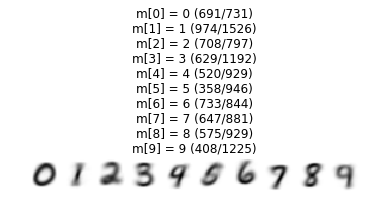

In [29]:
K = 10
avnum = 10
c_list = []
for k in np.arange(K):
    if k == 0:
        for i in range(avnum):
            c_list.append(x_train[y_train==k][i])
    else:
        for i in range(avnum):
            c_list[i] = np.vstack((c_list[i], x_train[y_train==k][i]))
c = c_list[0]
for i in range(1,avnum):
    c+=c_list[i]
c = c/avnum
km = Kmeans(x_train, c)
km.run()
km.show_cluster_centroids_and_majority_labels(y_train)

Since we already know class labels (`y_train`) for each data point, we can check the majority of labels (`m[k]`) for each cluster after _K_-means clustering is run to completion.

### Elbow Algorithm

The following script runs $K$-means clustering for different values of $K$ and produces a plot of cost function vs $K$.

K =    2, J =       6.9778
K =    4, J =       6.6648
K =    6, J =       6.4444
K =    8, J =       6.3268
K =   10, J =       6.2649
K =   12, J =       6.1491
K =   14, J =       6.0849
K =   16, J =       6.0237
K =   18, J =       5.9568
K =   20, J =       5.8888


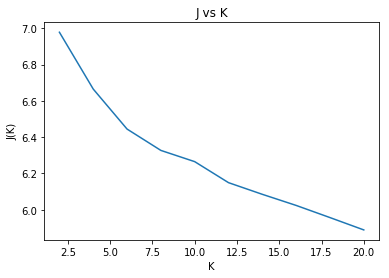

In [12]:
K_range = np.arange(2, 22, 2)
J = np.zeros(len(K_range))
i = 0
for K in K_range:    
    c = x_train[0:K].copy()
    km = Kmeans(x_train, c)
    km.run()
    J[i] = km.J
    print('K = {:4d}, J = {:12.4f}'.format(K, J[i]))
    i += 1
pl.figure()
pl.title('J vs K')
pl.plot(K_range, J)
pl.xlabel('K')
pl.ylabel('J(K)');

## Dimensionality Reduction using Principal Component Analysis (PCA)

In order to perfom PCA, we need to compute the mean vector and covariance matrix of the dataset. Note that in your class notes for PCA, datasets are represented in column-major order. In previous sections, we are using row-major order.

In [13]:
def find_principal_components(x, suppress_output=False):
    """
    Finds and returns the principal components.
    """
    N = x.shape[0]
    D = x.shape[1]
    mu = np.mean(x, axis = 0)
    C = 1.0 / (N-1) * np.dot((x-mu).T, (x-mu))
    LD, PD = np.linalg.eigh(C) # note that this produces eigenvalues (LD) and corresponding eigenvectors (PD) sorted in ascending order of eigenvalues
    LD = LD[::-1] # reverse LD
    PD = PD[:, ::-1] # reverse PD    
    if not suppress_output:
        pl.figure('Selected Eigenvalues')
        pl.plot(LD)
        pl.xlabel('Eigenvalue #')
        pl.ylabel('Eigenvalue')    
    return (mu, PD, LD)

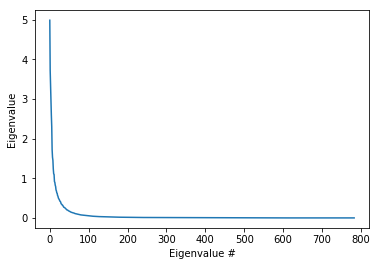

In [14]:
mu, PD, LD = find_principal_components(x_train)

As you notice from the above plot of all eigenvalues, majority of eigenvalues have small values. Thus we can use total variation as a metric to select the significant principal components, i.e.:

In [31]:
delta = 0.99 # total variation
d = np.argwhere(delta < np.cumsum(LD)/np.sum(LD))[0][0] # very first index of normalised cumulative sum of eigenvalues satisfying total variation requirement
print('The number of principal components satisfying total variation of {:.2f} is {:d}'.format(delta, d))

The number of principal components satisfying total variation of 0.99 is 327


As you can see above, even if we want to retain 99% of total variation, reduced dimensionality $d$ is significantly smaller than the dimensionality $D$ of data points. Lets display those $d$ eigenvectors.

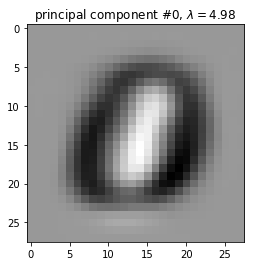

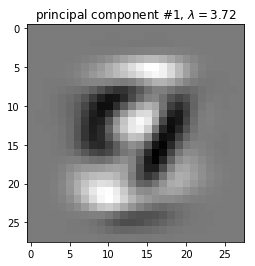

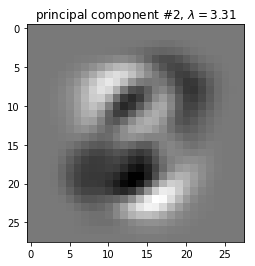

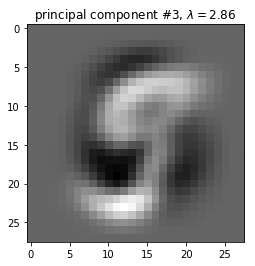

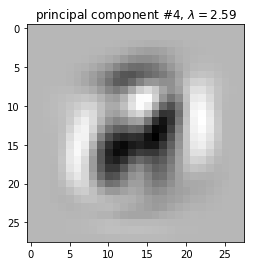

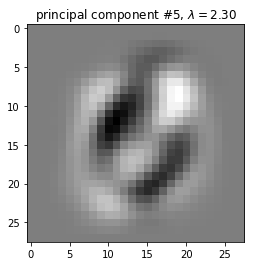

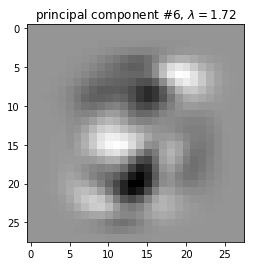

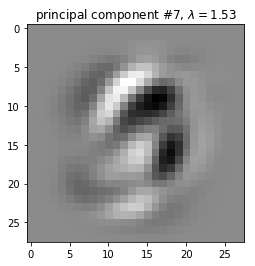

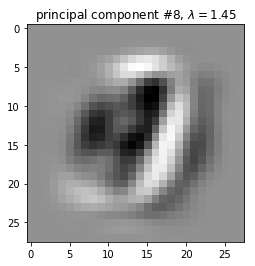

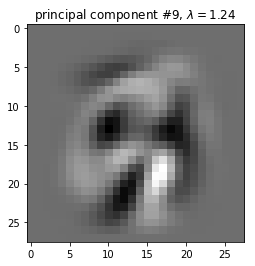

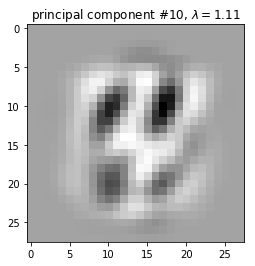

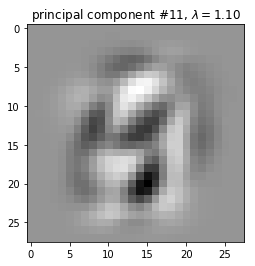

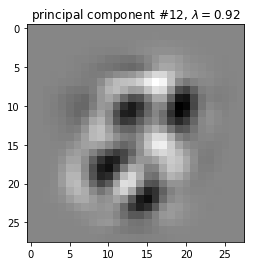

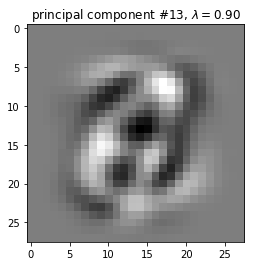

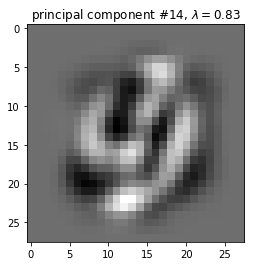

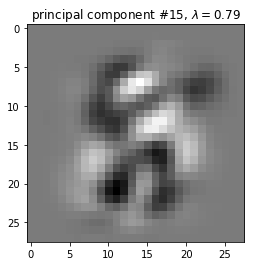

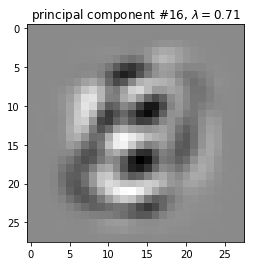

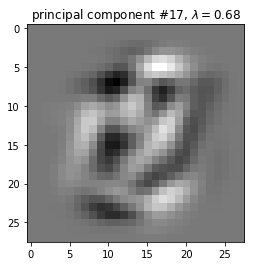

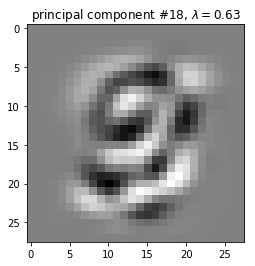

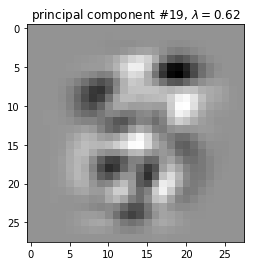

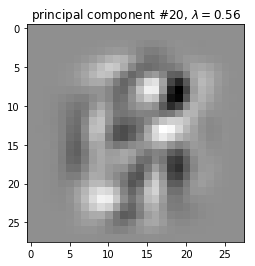

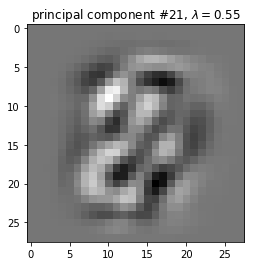

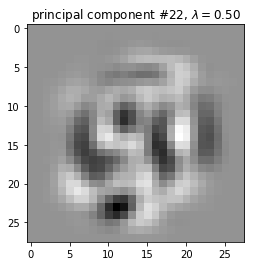

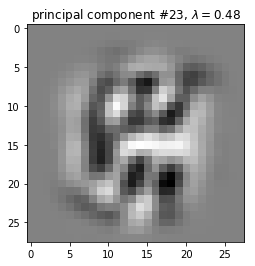

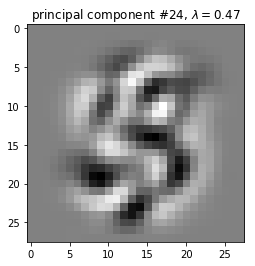

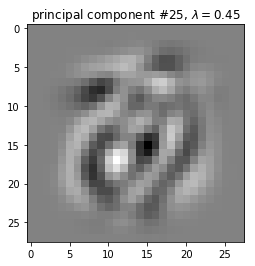

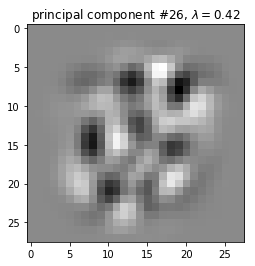

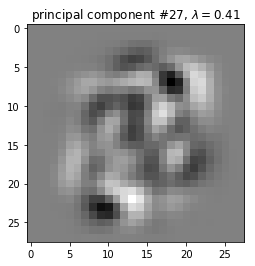

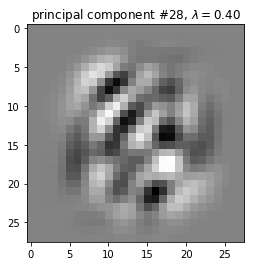

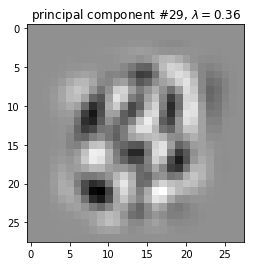

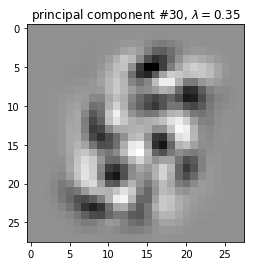

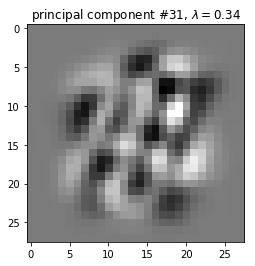

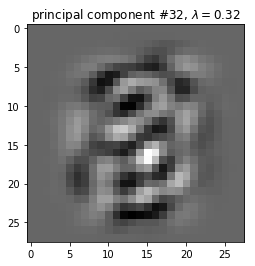

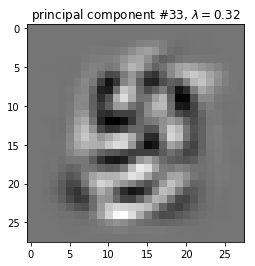

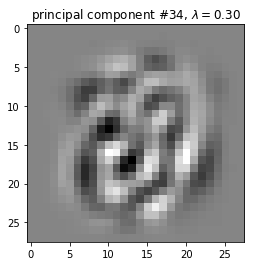

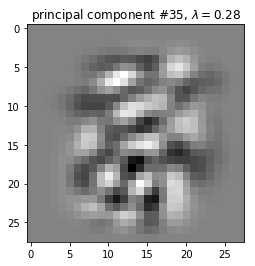

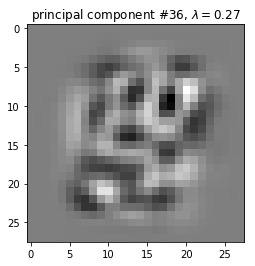

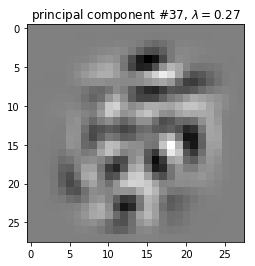

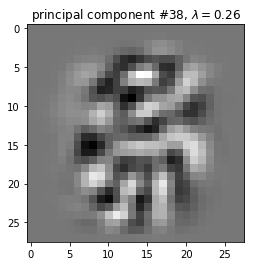

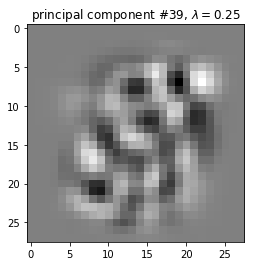

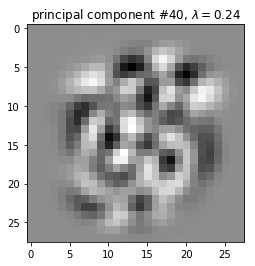

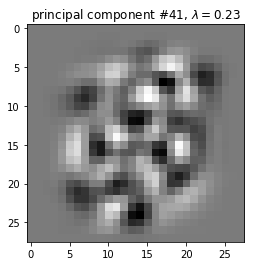

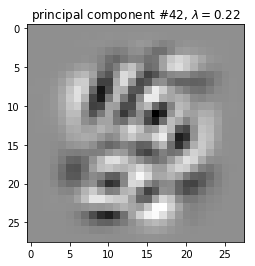

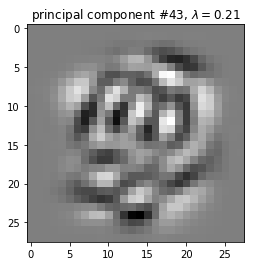

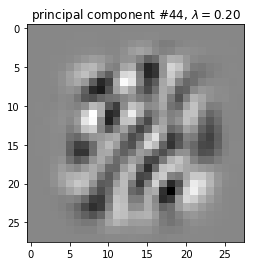

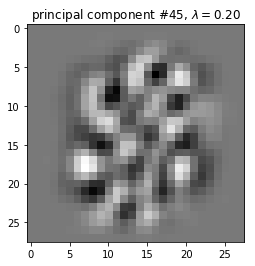

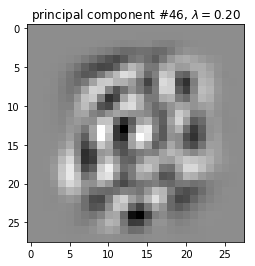

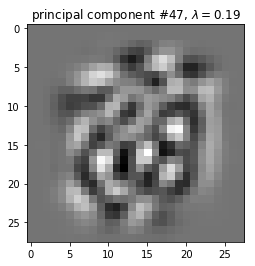

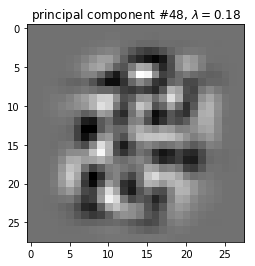

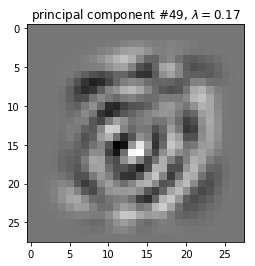

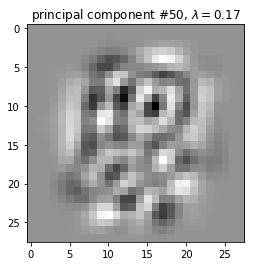

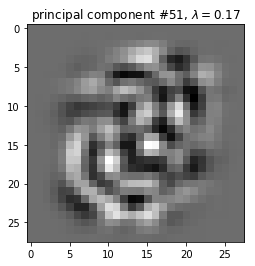

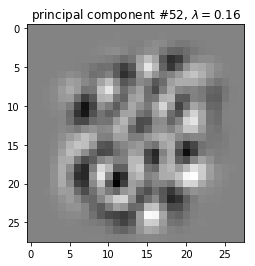

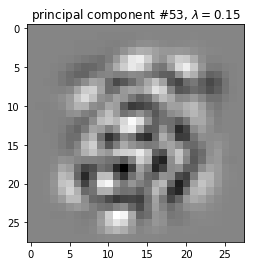

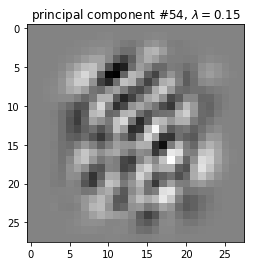

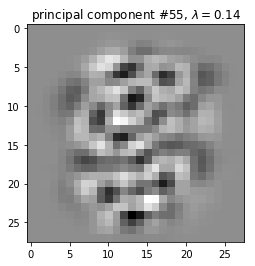

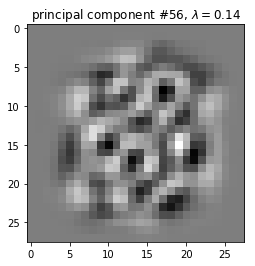

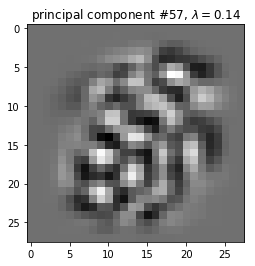

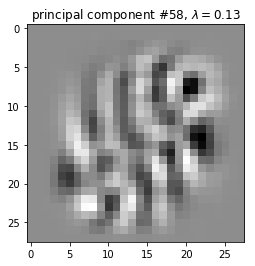

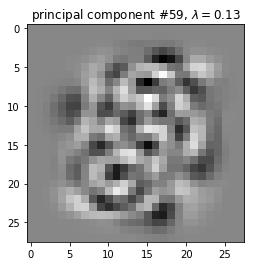

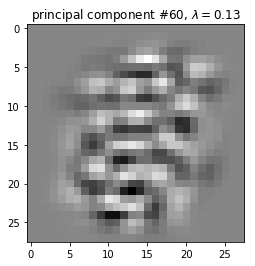

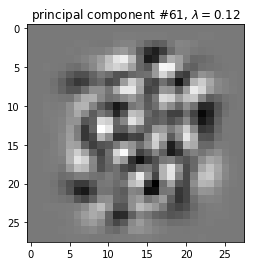

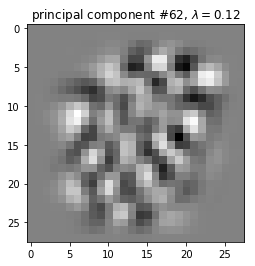

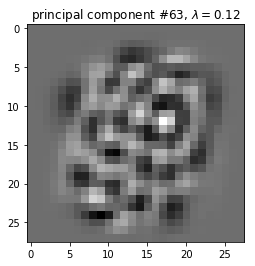

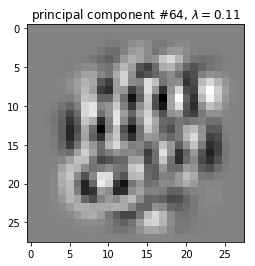

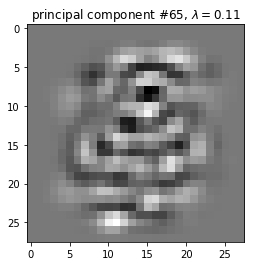

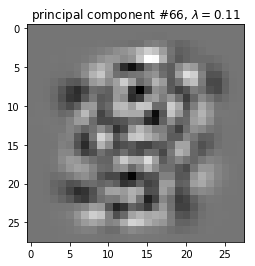

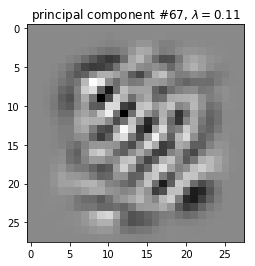

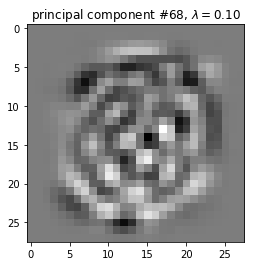

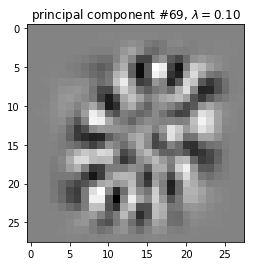

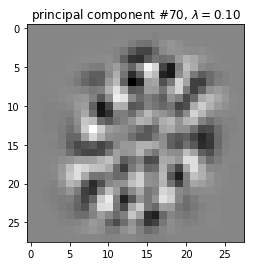

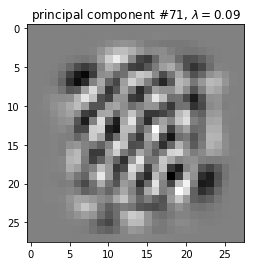

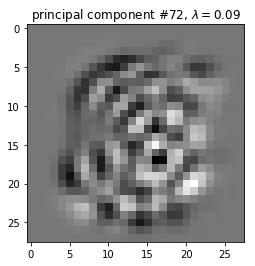

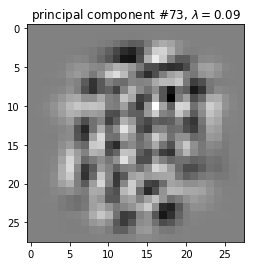

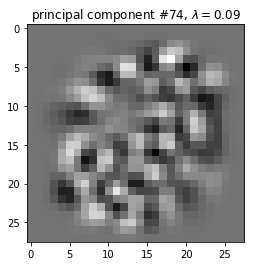

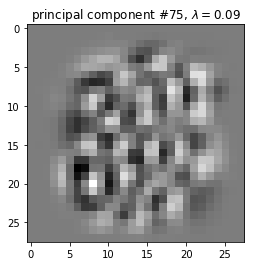

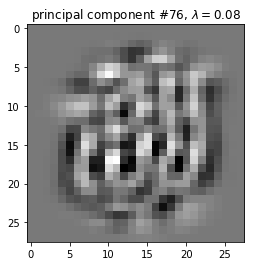

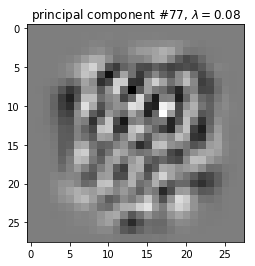

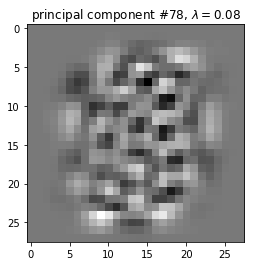

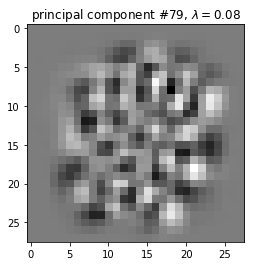

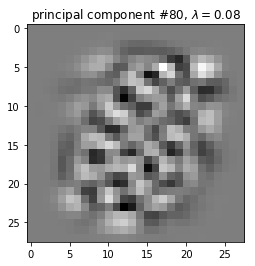

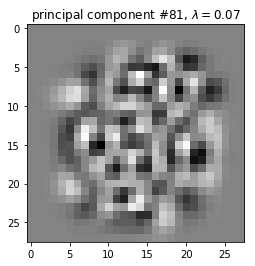

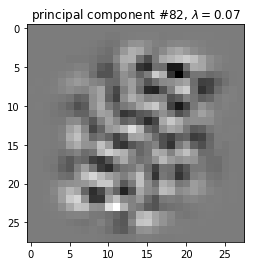

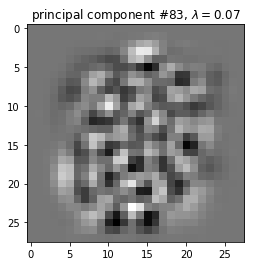

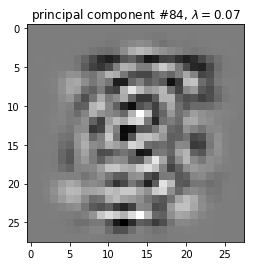

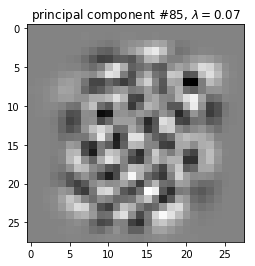

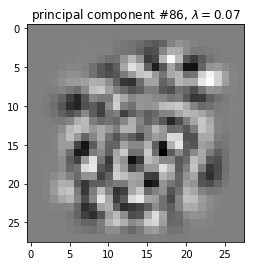

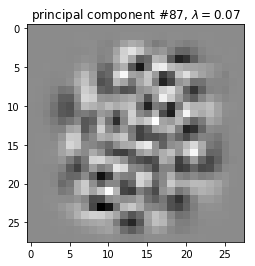

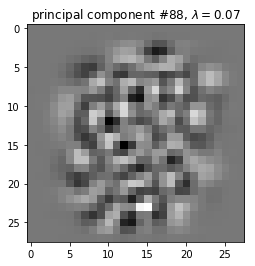

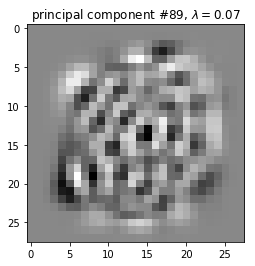

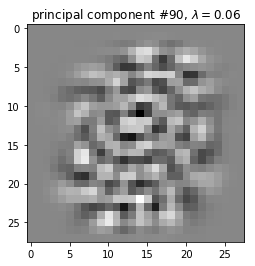

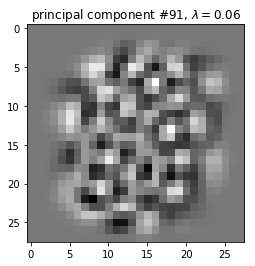

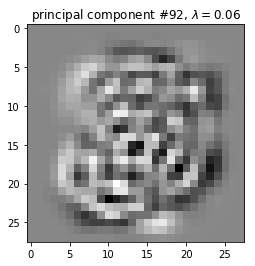

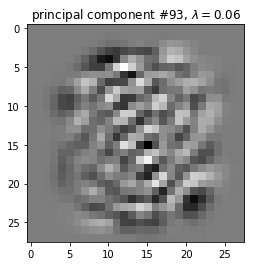

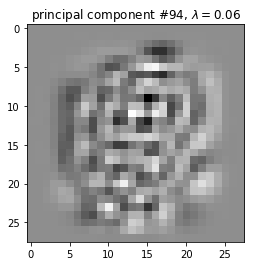

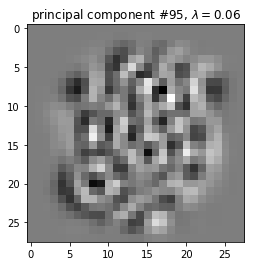

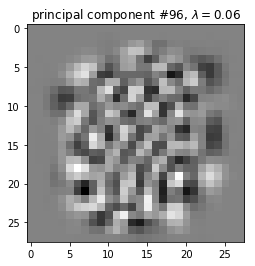

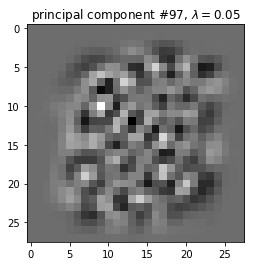

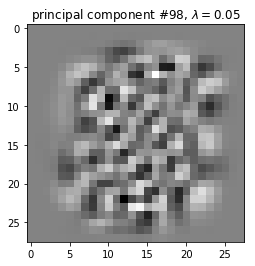

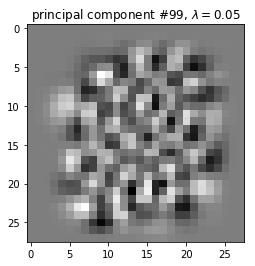

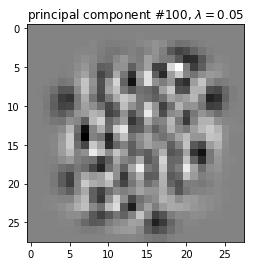

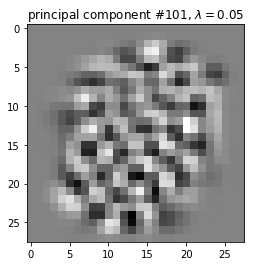

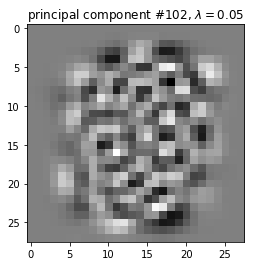

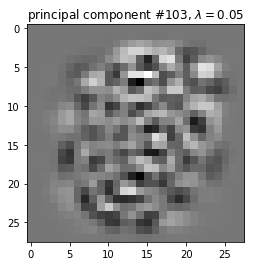

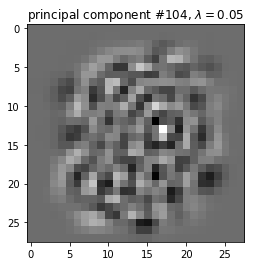

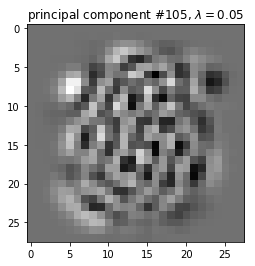

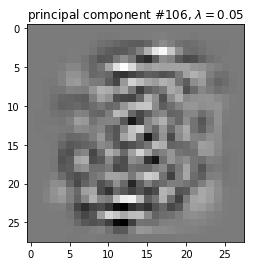

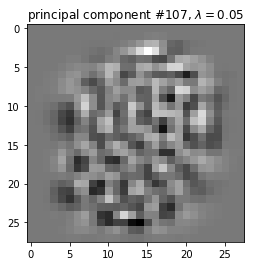

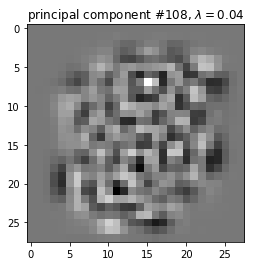

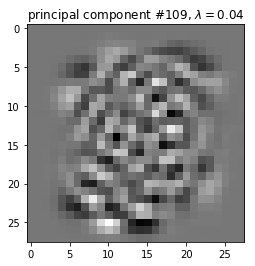

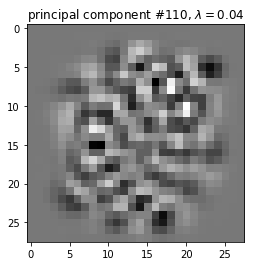

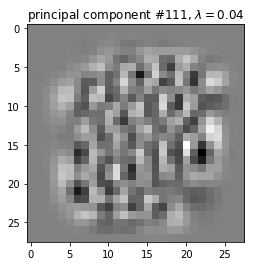

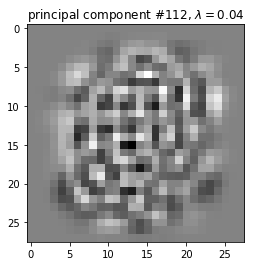

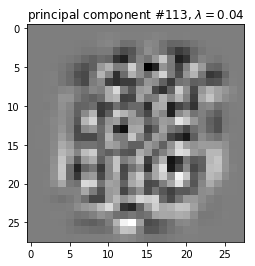

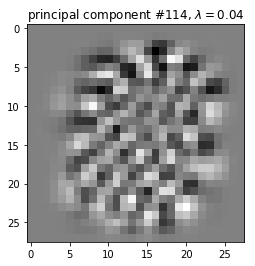

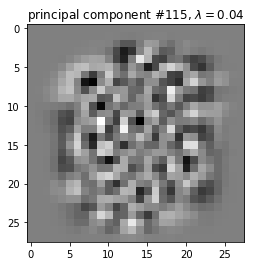

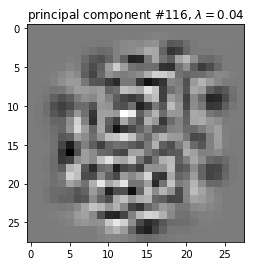

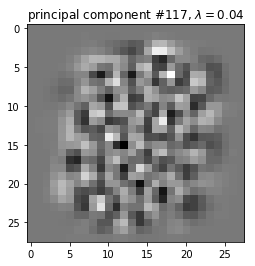

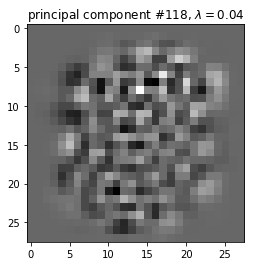

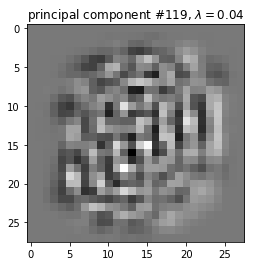

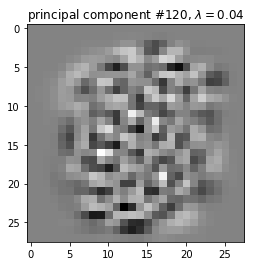

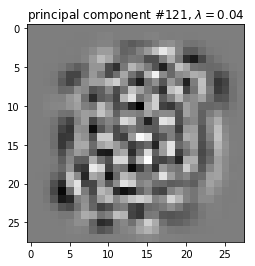

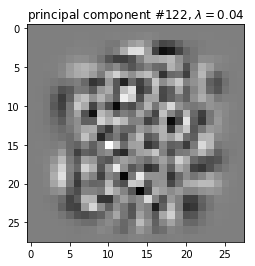

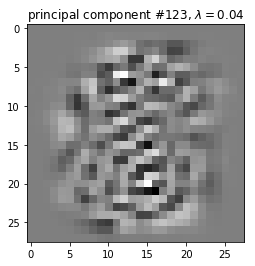

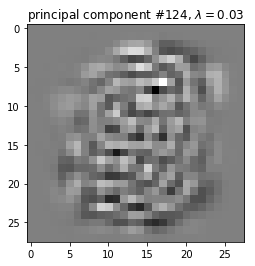

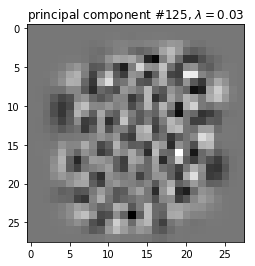

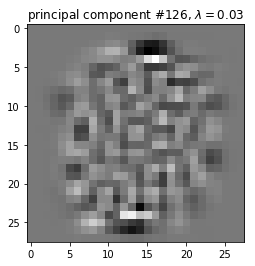

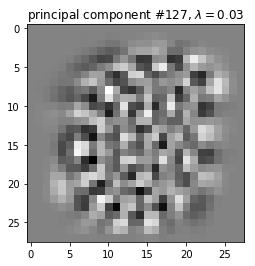

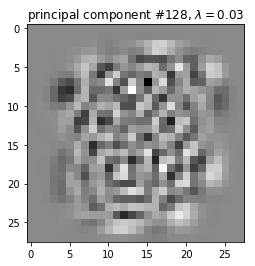

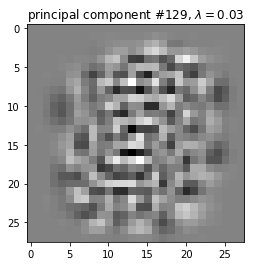

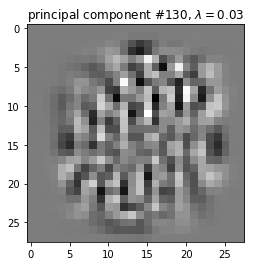

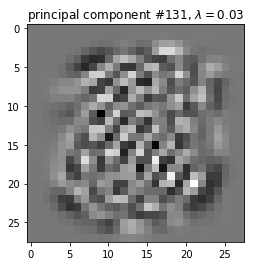

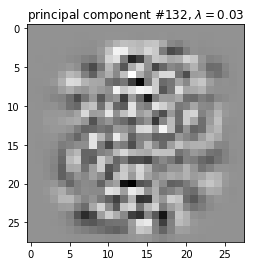

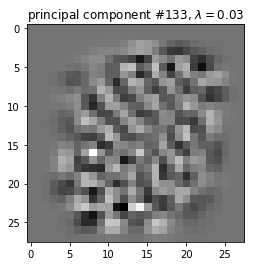

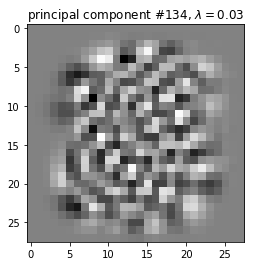

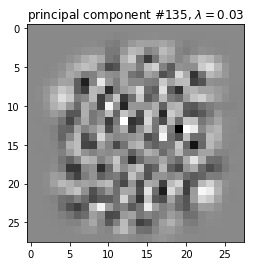

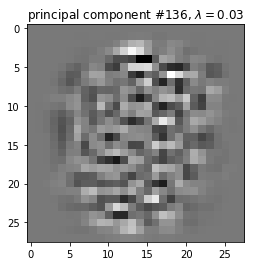

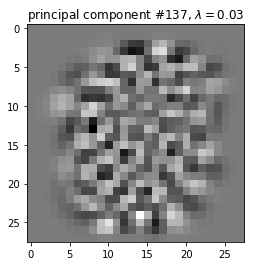

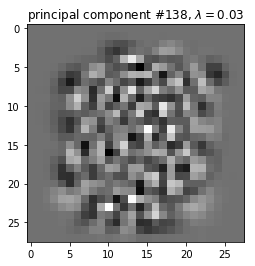

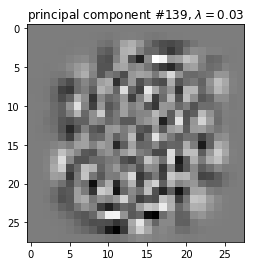

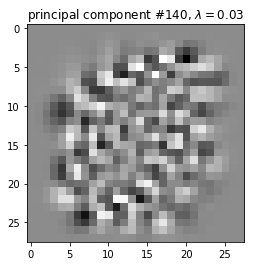

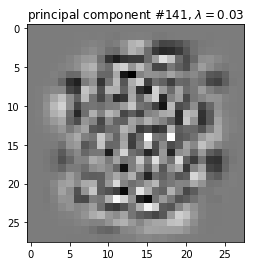

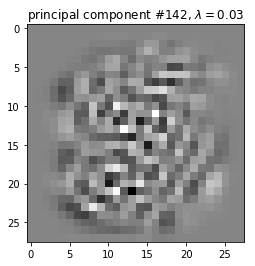

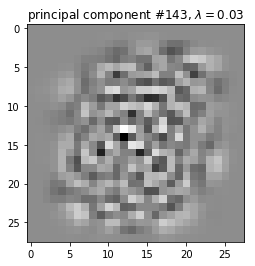

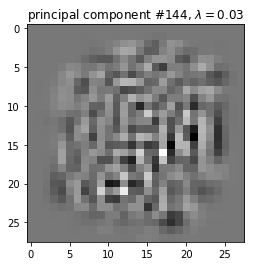

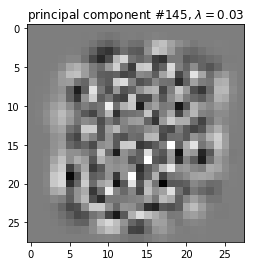

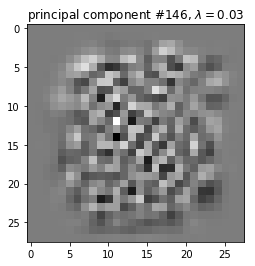

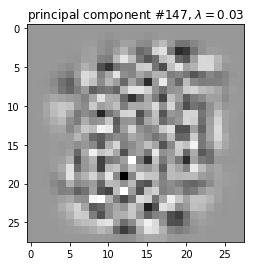

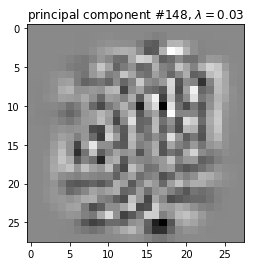

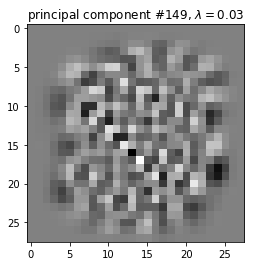

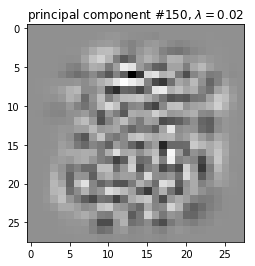

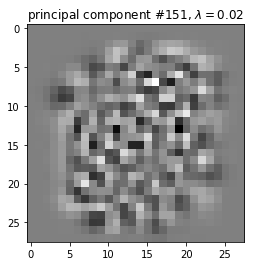

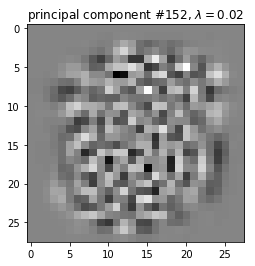

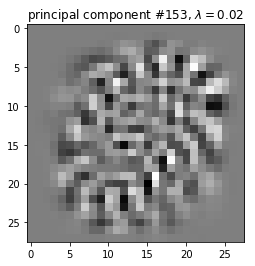

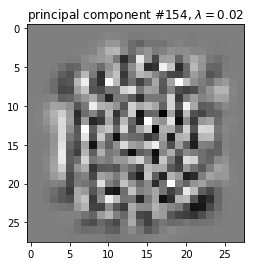

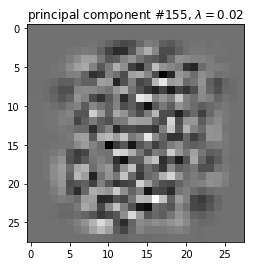

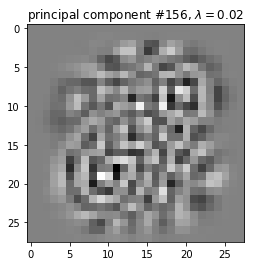

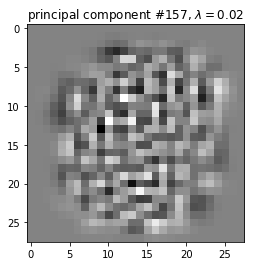

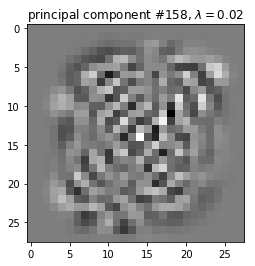

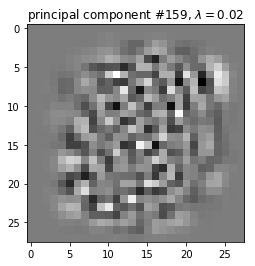

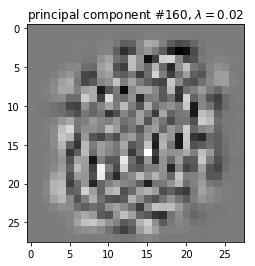

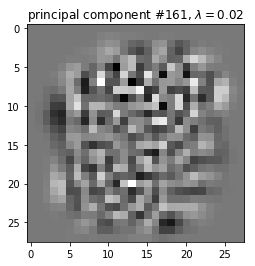

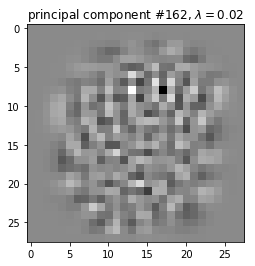

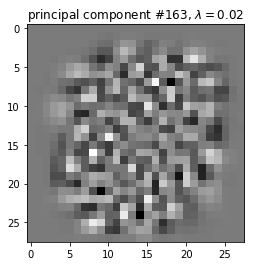

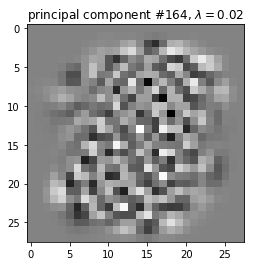

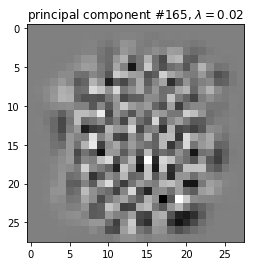

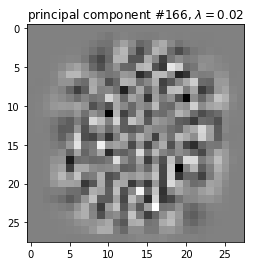

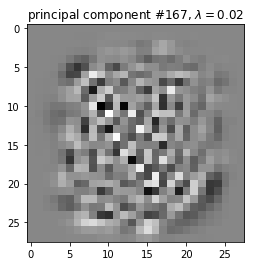

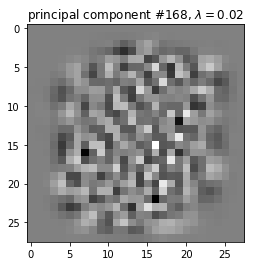

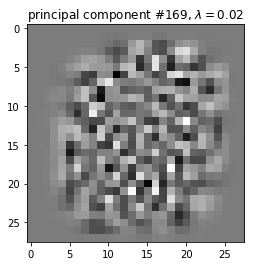

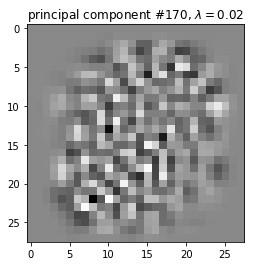

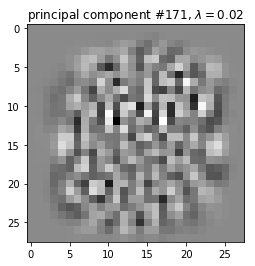

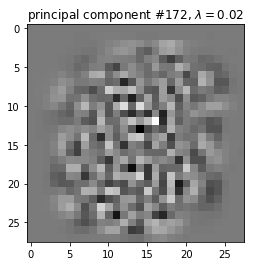

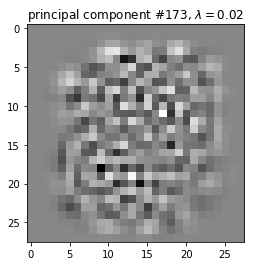

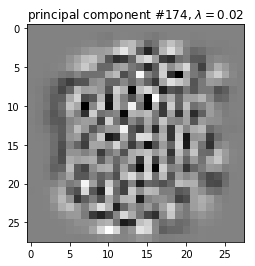

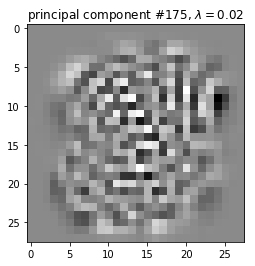

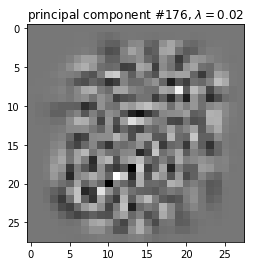

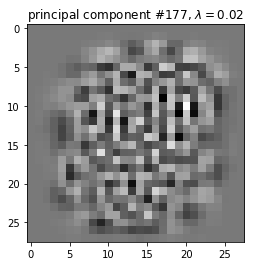

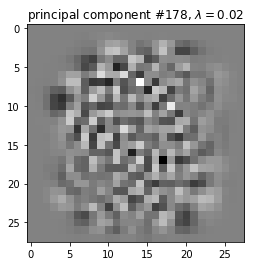

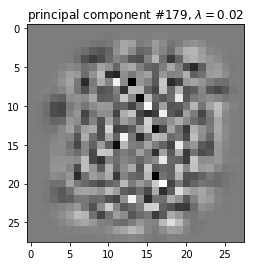

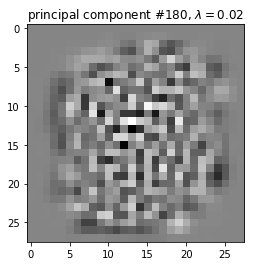

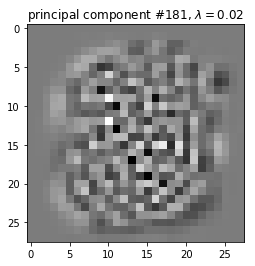

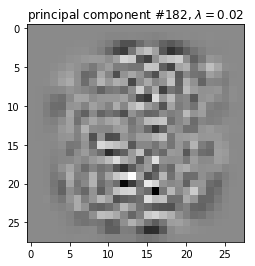

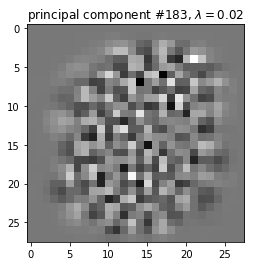

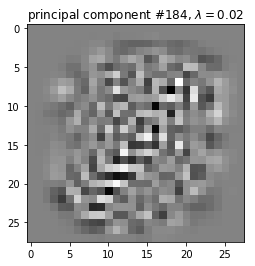

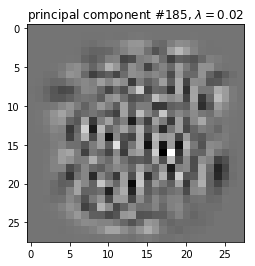

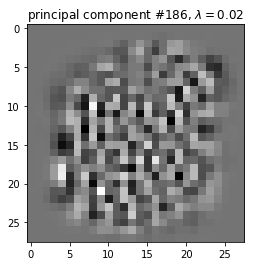

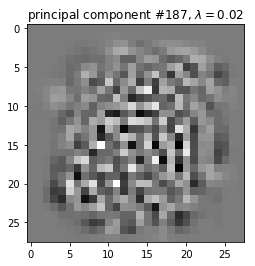

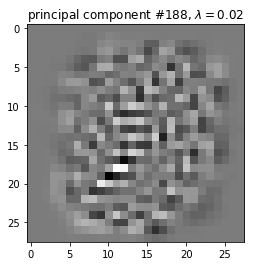

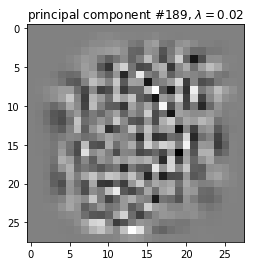

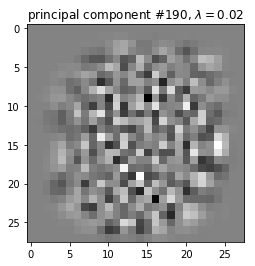

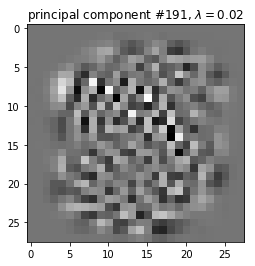

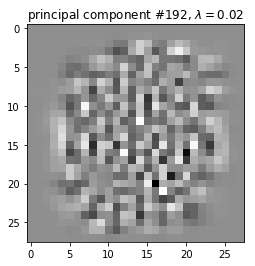

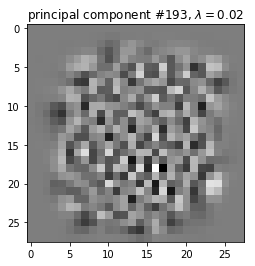

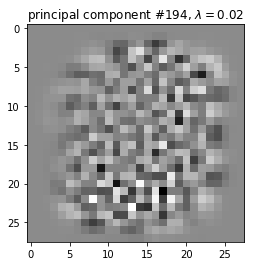

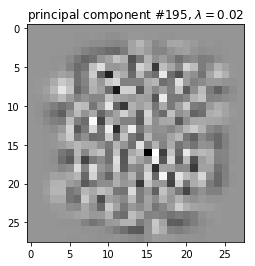

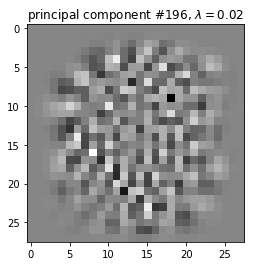

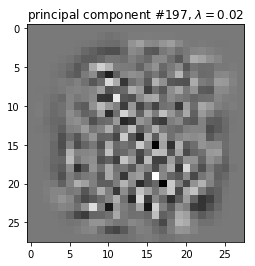

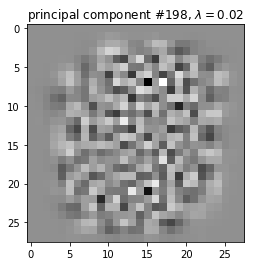

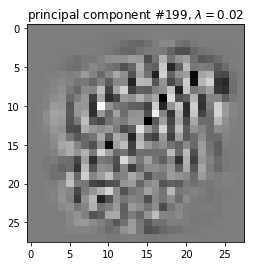

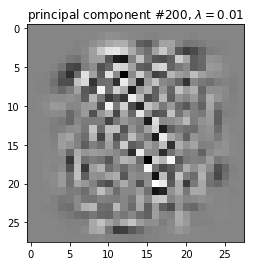

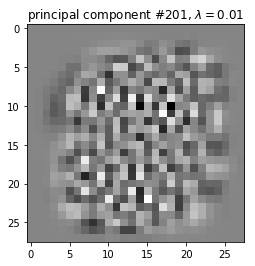

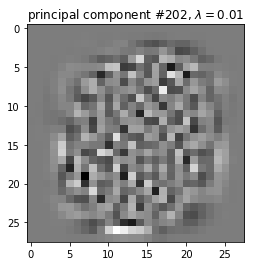

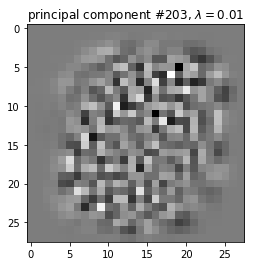

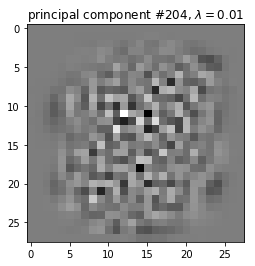

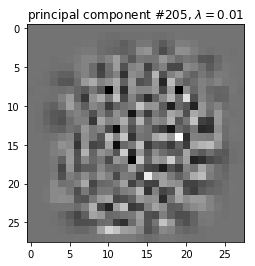

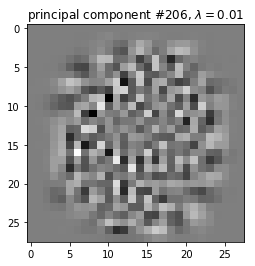

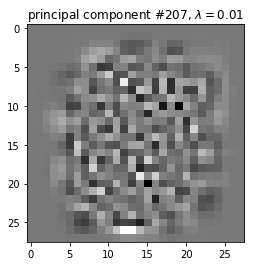

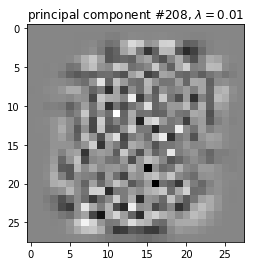

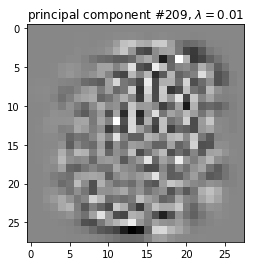

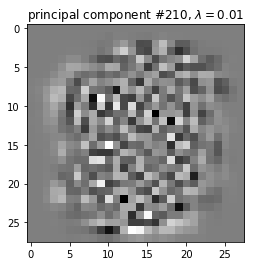

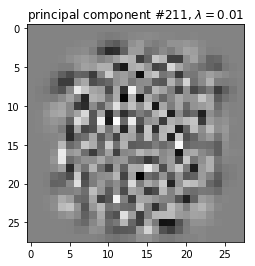

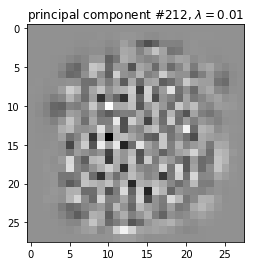

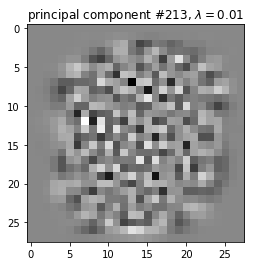

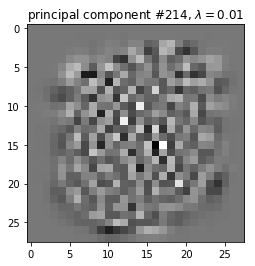

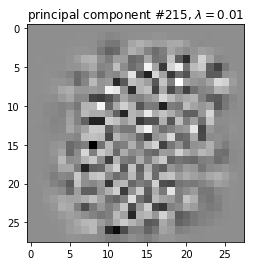

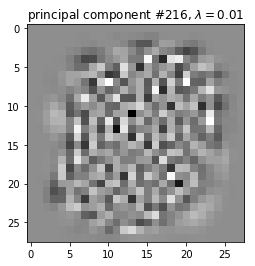

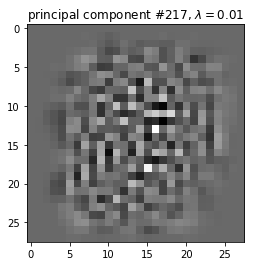

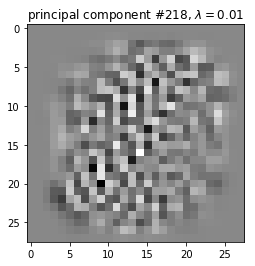

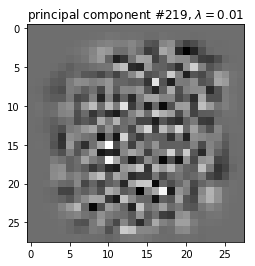

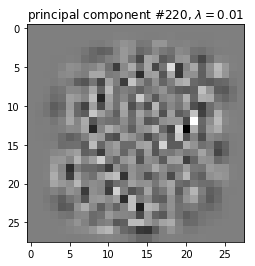

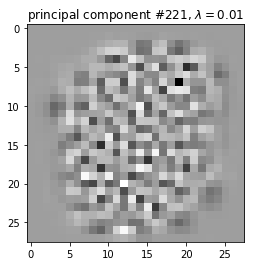

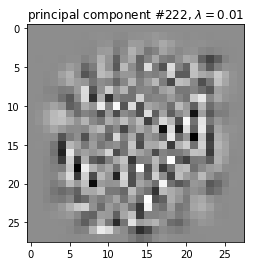

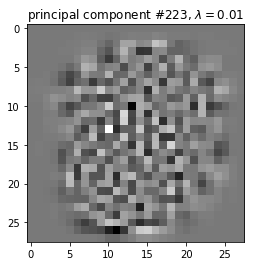

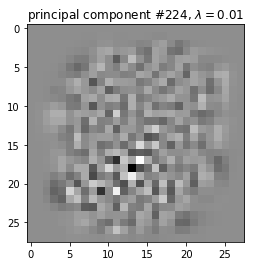

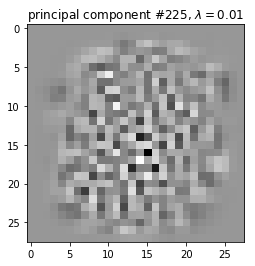

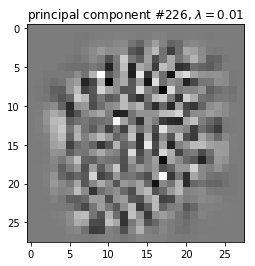

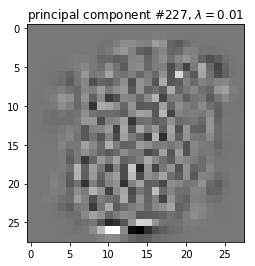

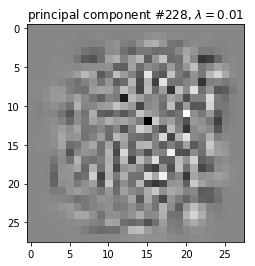

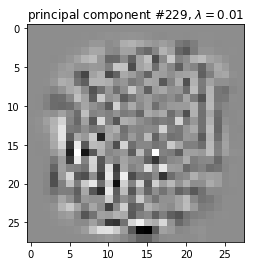

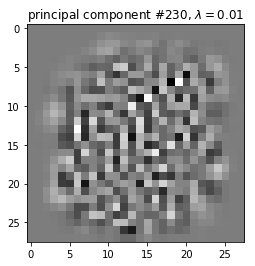

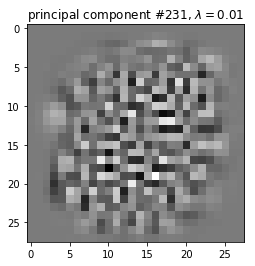

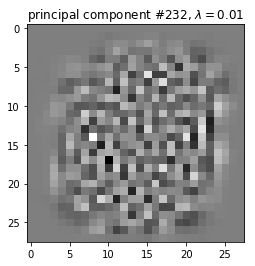

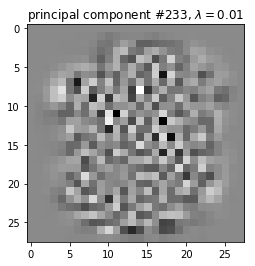

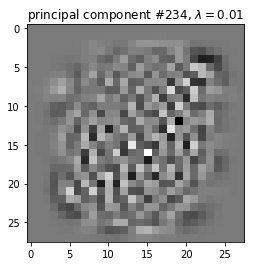

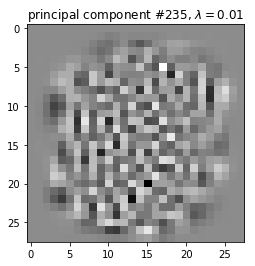

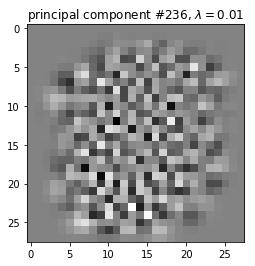

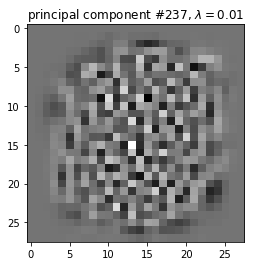

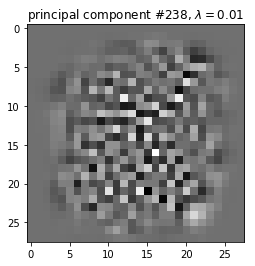

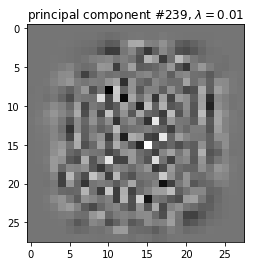

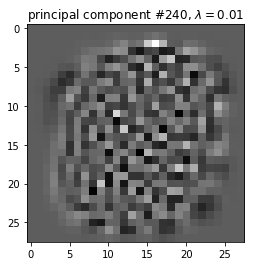

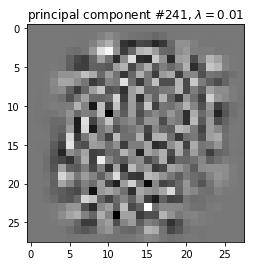

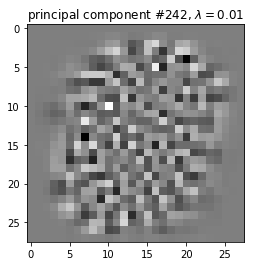

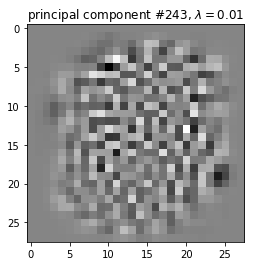

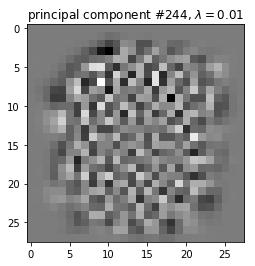

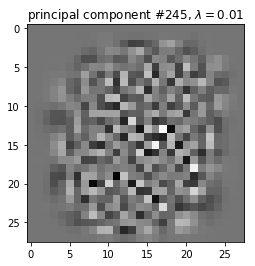

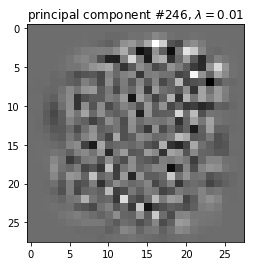

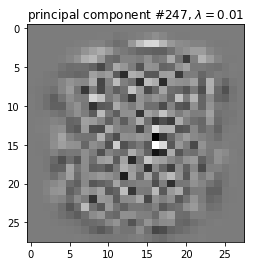

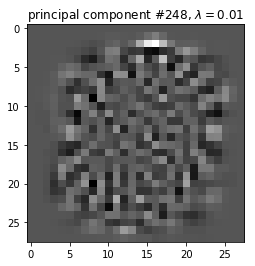

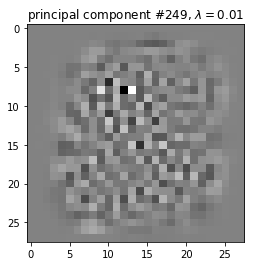

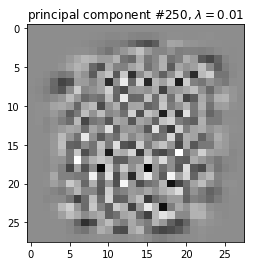

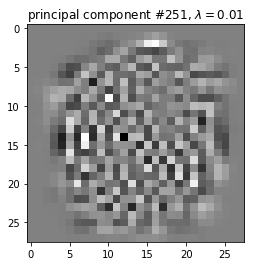

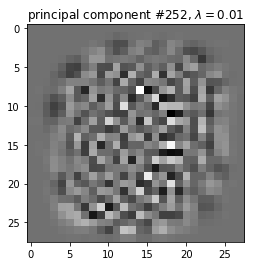

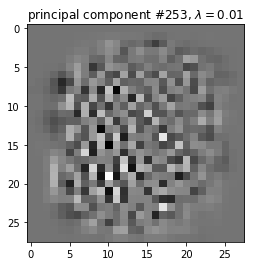

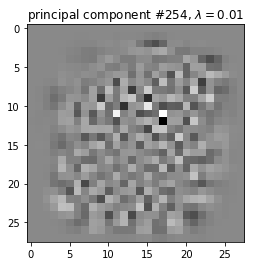

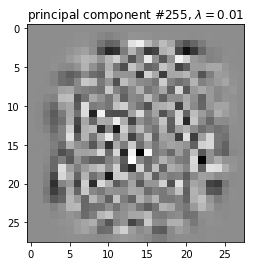

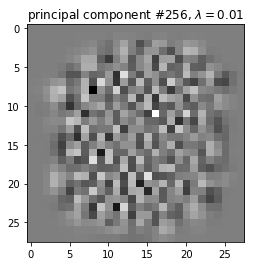

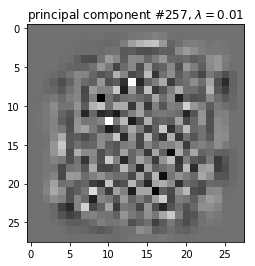

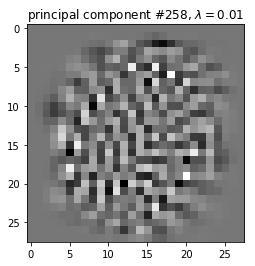

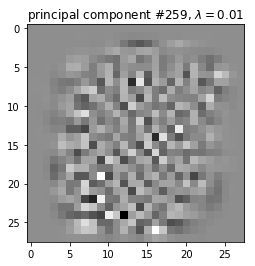

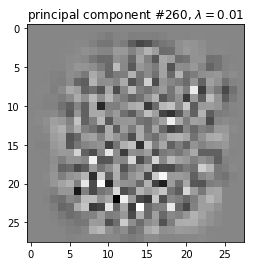

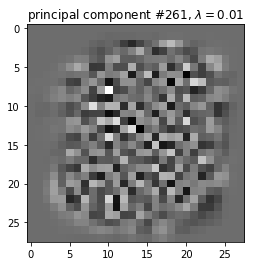

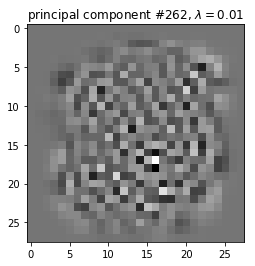

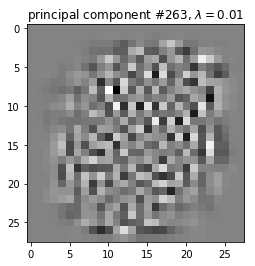

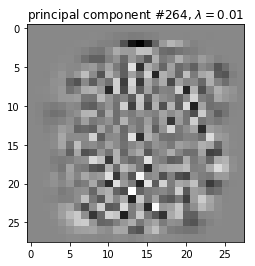

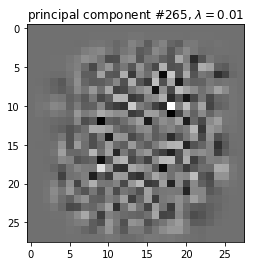

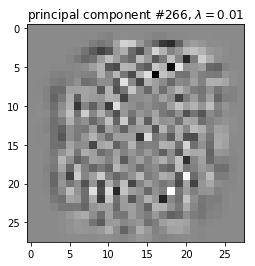

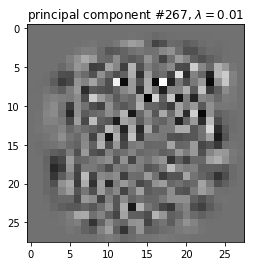

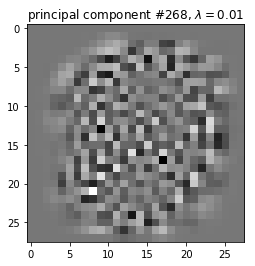

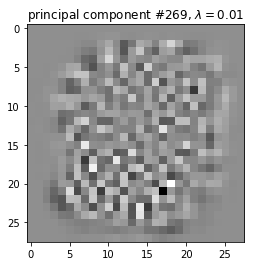

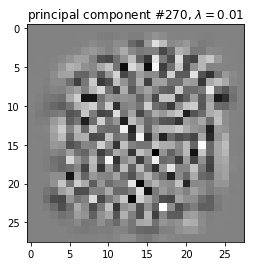

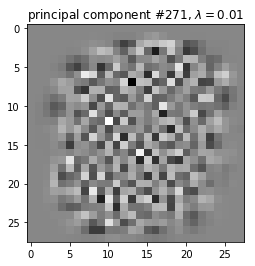

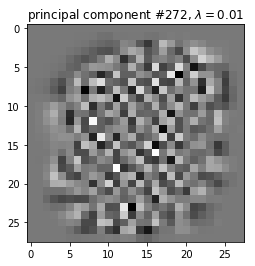

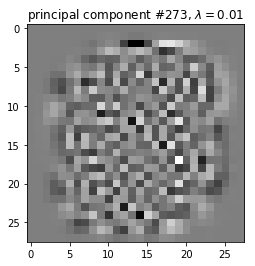

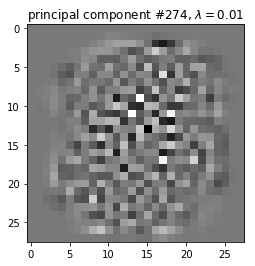

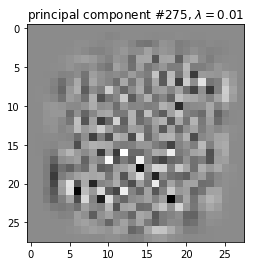

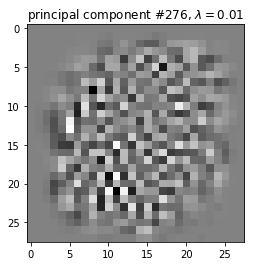

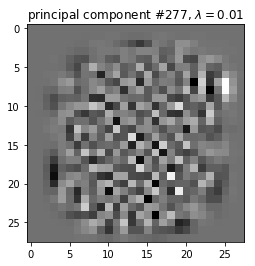

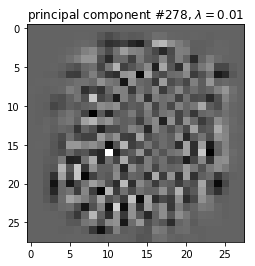

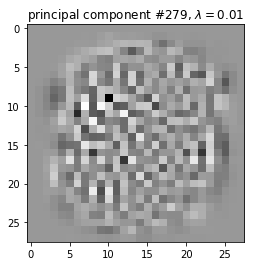

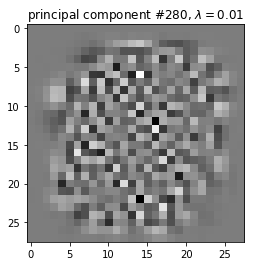

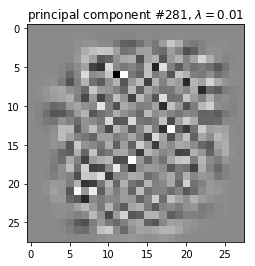

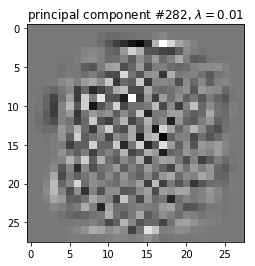

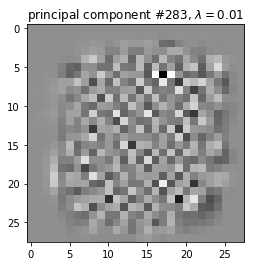

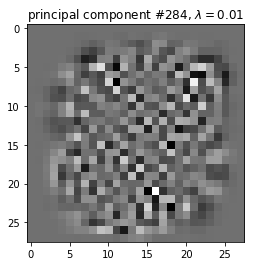

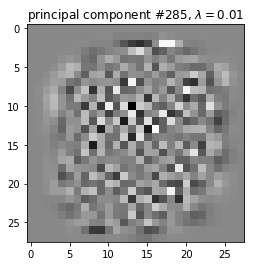

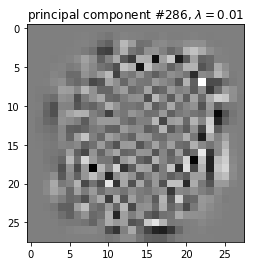

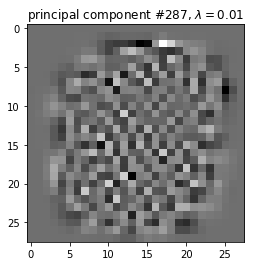

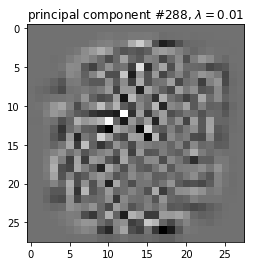

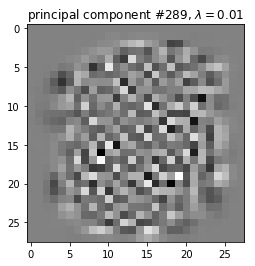

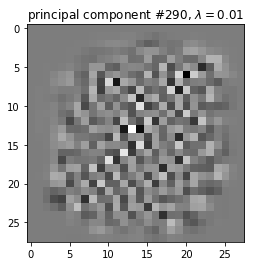

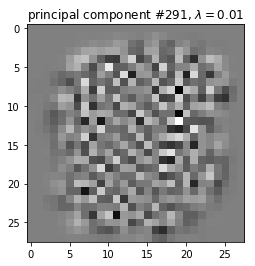

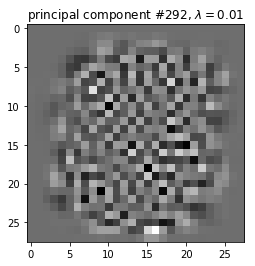

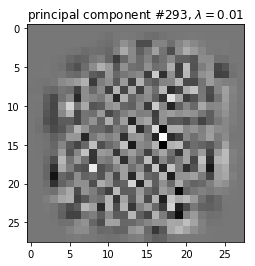

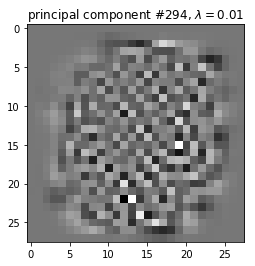

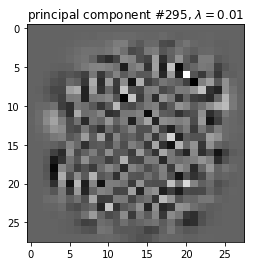

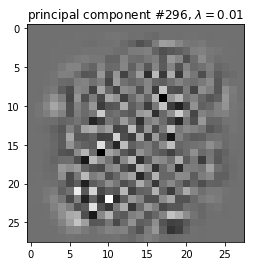

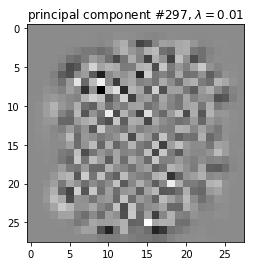

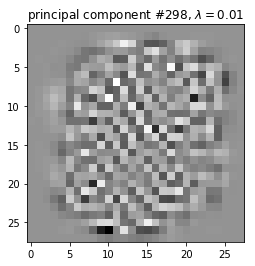

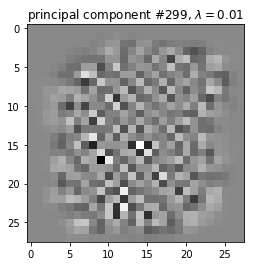

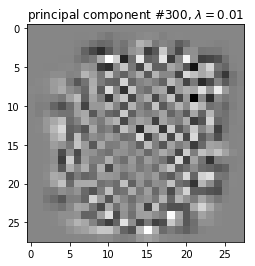

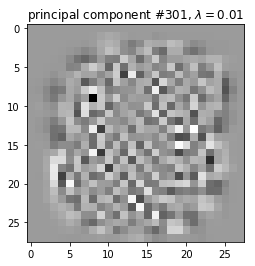

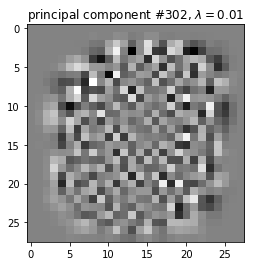

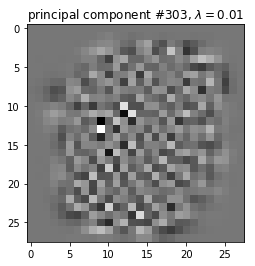

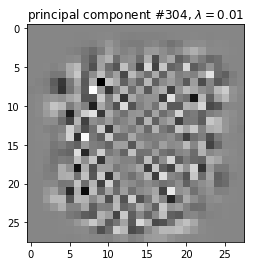

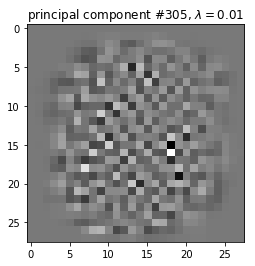

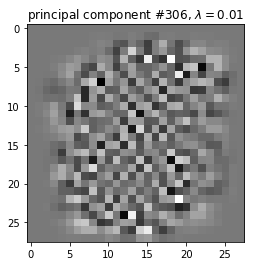

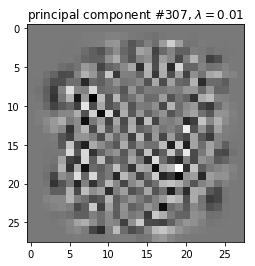

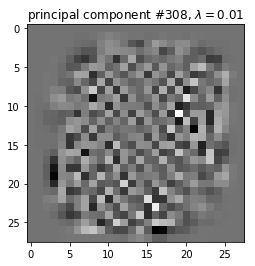

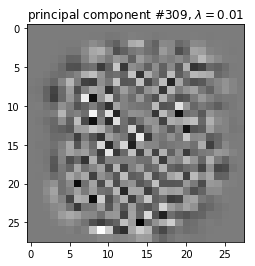

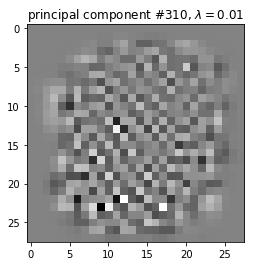

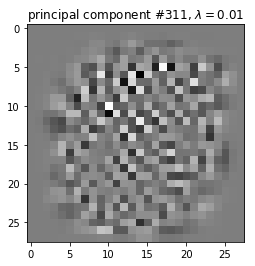

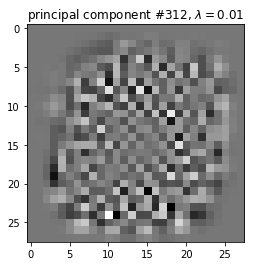

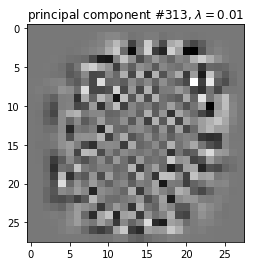

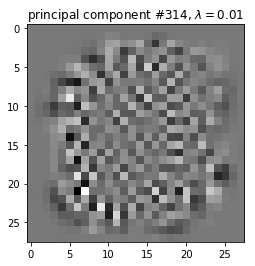

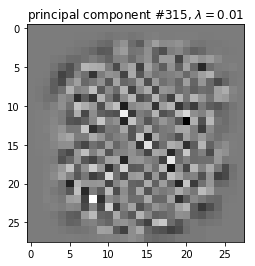

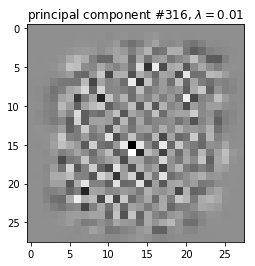

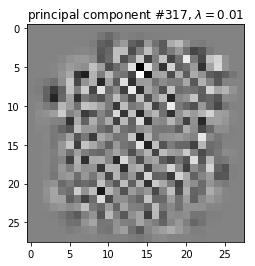

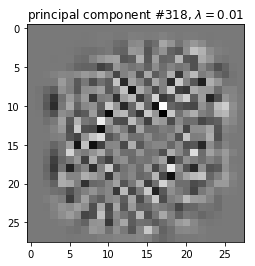

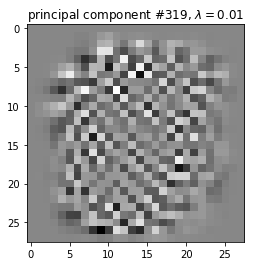

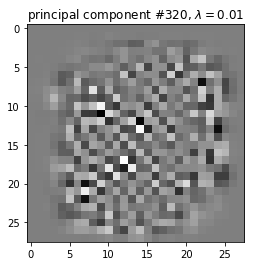

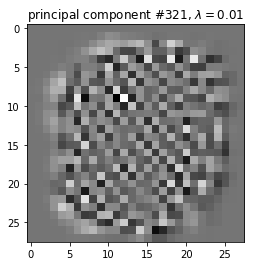

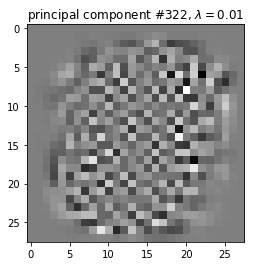

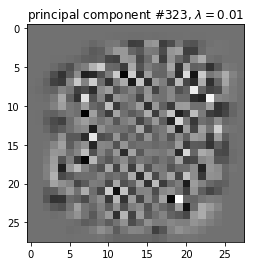

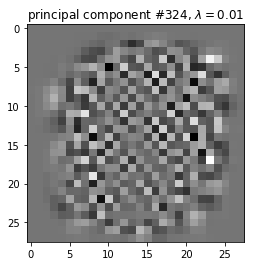

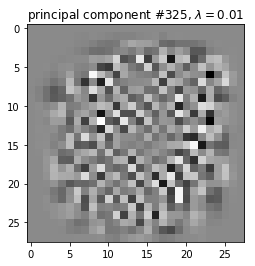

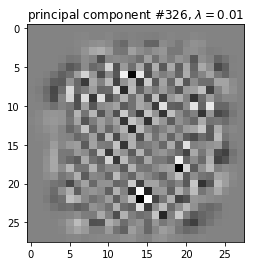

In [32]:
for i in np.arange(d):
    image = vector2image(PD[:,i])
    pl.figure()
    pl.imshow(image, cmap='gray')
    pl.title('principal component #{:d}, $\lambda={:.2f}$'.format(i,LD[i]))
    pl.show()    

Do you think principal components above are meaningful? How do you interpret them?

<b>Answer:</b> For PC number 0, the digits are all centered in the middle of the image, averaging out to a circle shape. The white inside the circle shows that there is high variation in the middle of the region, and the gray outside shows that there is low variation in the background of the digits. Subsequent PCs represent variations to that average circle shape, with the last ones representing noise in the data

### Data Projection

The following script reduces the dimensionality of a data point to $d=2$ by projecting it onto a vector space of two principal components (2-rank approximation).

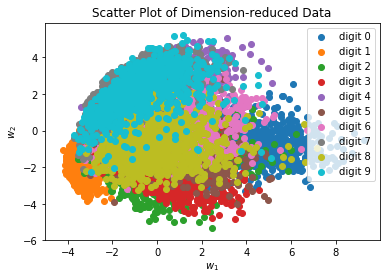

In [33]:
d = 2
Pd = PD[:, 0:d] # let's only select d of eigenvectors to reduce the dimensionality of feature vectors from D to d
W = np.dot((x_train - mu), Pd) # subtract mean vector from each row of x_train and project the difference onto reduced dimensionality eigenvector space
pl.figure()
pl.title('Scatter Plot of Dimension-reduced Data')
K = 10
for k in np.arange(K):
    pl.scatter(W[y_train==k][:, 0], W[y_train==k][:, 1], label='digit {:d}'.format(k))
pl.xlabel(r'$w_{1}$')
pl.ylabel(r'$w_{2}$')
pl.legend();

### Data Reconstruction: $d$-Rank Approximation


Lets reconstruct data using $d$-rank approximation and display some of the reconstructed data along with the original data.

In [18]:
x_train_reconstructed = mu + np.dot(W, Pd.T)

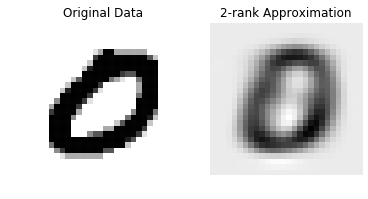

In [19]:
index = 0
pl.figure()
pl.subplot(1, 2, 1)
pl.imshow(vector2image(x_train[index, :]), cmap='gray')
pl.axis('off')
pl.title('Original Data')
pl.subplot(1, 2, 2)
pl.imshow(vector2image(x_train_reconstructed[index, :]), cmap='gray')
pl.axis('off')
pl.title('{:}-rank Approximation'.format(d));

Lets observe higher-order _d_-rank approximations!

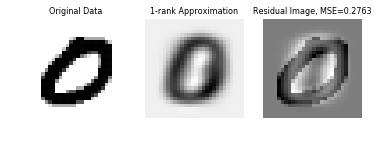

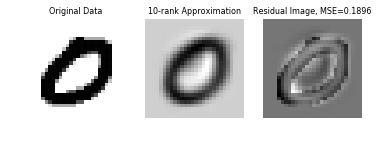

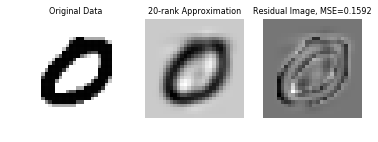

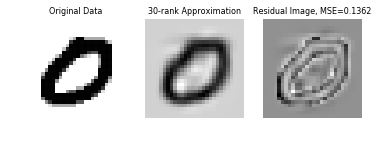

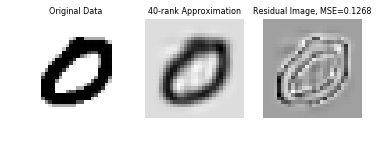

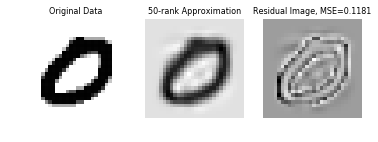

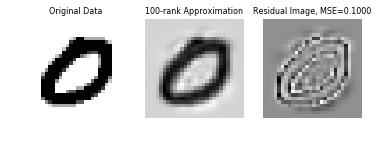

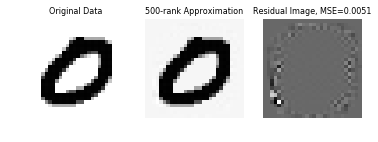

In [20]:
index = 0
x_original = x_train[index][np.newaxis, :]
for d in [1, 10, 20, 30, 40, 50, 100, 500]:
    Pd = PD[:, 0:d]
    W = np.dot((x_original - mu), Pd)
    x_reconstructed = mu + np.dot(W, Pd.T)
    x_residual = x_original - x_reconstructed
    pl.figure()
    pl.subplot(1, 3, 1)
    pl.imshow(vector2image(x_original), cmap='gray')
    pl.axis('off')
    pl.title('Original Data', fontsize=8)
    pl.subplot(1, 3, 2)
    pl.imshow(vector2image(x_reconstructed), cmap='gray')
    pl.axis('off')
    pl.title('{:}-rank Approximation'.format(d), fontsize=8)
    pl.subplot(1, 3, 3)
    pl.imshow(vector2image(x_residual), cmap='gray')
    pl.axis('off')
    pl.title('Residual Image, MSE={:.4f}'.format(np.sqrt(np.mean(x_residual**2))), fontsize=8)

What happens to the residual between original and reconstructed data with $d$-rank approximation when you make the order of approximation higher?

Now let's do K-means again, but with the reduced space

In [34]:
print(x_reconstructed.shape)

(1, 784)


# Anomaly Detection

Based on your ACML lecture notes, we will use multivariate Gaussian density (`mgd`) estimator for anomaly detection. In order to use multivariate Gaussian density as a parametric density estimator, one needs to first estimate the parameters of the density estimator. In the following, lets use samples of digit 1 to represent normal behaviour and samples of digit 7 to represent anomoulous behaviour and form a dataset.

In [21]:
d = 2
mu = np.mean(x_train, axis=0)
W = np.dot((x_train - mu), PD[:,0:d])

x_normal = W[y_train==1]
y_normal = np.zeros(x_normal.shape[0], dtype=np.int)
x_anomaly = W[y_train==7]
y_anomaly = np.ones(x_anomaly.shape[0], dtype=np.int)
x = np.vstack((x_normal, x_anomaly))
y = np.hstack((y_normal, y_anomaly))

## Multivariate Gaussian Density Estimator

In [22]:
def mgd(x, mu, sigma):
    """
    Computes and returns the multivariate Gaussian probability for the input x. It assumes that x and mu are row vectors.
    """
    d = mu.shape[1]
    sigma_inv = np.linalg.inv(sigma)
    sigma_det = np.linalg.det(sigma)
    p = 1.0/((2 * np.pi)**(d/2.0) * sigma_det**(0.5)) * np.exp(-1/2.0 * np.dot((x-mu), np.dot(sigma_inv, (x-mu).T)))[0][0]
    return p

## Mean Vector and Covariance Matrix for Normal Class

In [23]:
mu_normal = np.mean(x_normal,axis=0)[np.newaxis, :]
sigma_normal = 1.0 / (x_normal.shape[0]-1) * np.dot((x_normal-mu_normal).T, (x_normal-mu_normal))

The following script selects a sample from both normal anomaly classes and computes corresponding probabilities

In [24]:
x = x_normal[0][np.newaxis, :]
print('a normal sample with probability of {:.8f}'.format(mgd(x, mu_normal, sigma_normal)))

x = x_anomaly[0][np.newaxis, :]
print('an anomaly sample with probability of {:.8f}'.format(mgd(x, mu_normal, sigma_normal)))

a normal sample with probability of 0.08993446
an anomaly sample with probability of 0.00000000


__Now your task is to implement the rest of anomaly detection algorithm!!!__